In [1]:
# import everything you need
import numpy as np
import scipy as sp
import pandas as pd
# activate inline magics
%matplotlib inline 
# import matplotlib.pyplot as plt
# import matplotlib.image as mpl_img
import seaborn as sns
# specific fo statistics
import pingouin as pg

Define neccesary parameters

In [2]:
data_file = "FED_fMRI_fullcodesfixed_final.xls"
covariate_file = "FED_Subject_Covariates.xls"

Create the neccessary factors and sort all variables appropriately

In [3]:
# extract - data from list in .xls file(s). Outliers and all known errors have already been corrected (see recent "ALLCODESFIXED")
# read relevant content
anova = pd.read_excel(data_file, sheet_name="Sheet1",
                      usecols = ['Subject', 'Condition', 'RT'])
covariates = pd.read_excel(covariate_file, sheet_name="analysis",
                           usecols = ['FED_ID', 'BDI_22_Score', 'Gender', 'Age', 'Race'])

# remove first six subjects
anova = anova[(anova.Subject.isin(range(7, 69)))]
covariates = covariates[(covariates.FED_ID.isin(range(7, 69)))]

# create variables cue_valence and cue_validity after Condition and assign values according to trial codings (neg, pos, neu) (valid, invalid)
neg, pos, neu = [1, 4, 7, 10], [2, 5, 8, 11], [3, 6, 9, 12]
valid, invalid = [val for val in range(7, 13)], [val for val in range(1, 7)]
# create list of group, valence and validity numerical indices
group_cats, valence_cats, validity_cats = ["dep", "con"], ["neg", "pos", "neu"], ["valid", "invalid"]
# copy Condition list and replace
anova['Cue_Valence'] = anova['Condition']
for valence, name in zip([neg, pos, neu], valence_cats):
    anova.loc[anova['Condition'].isin(valence), 'Cue_Valence'] = name

anova['Cue_Validity'] = anova['Condition']
for validity, name in zip([valid, invalid], validity_cats):
    anova.loc[anova['Condition'].isin(validity), 'Cue_Validity'] = name

# create variable DStatus after Subject and replace each subject value with the corresponding group identity
# separate covariate FED_IDs by BDI22
mdd = covariates.FED_ID[covariates['BDI_22_Score'] == 1]
control = covariates.FED_ID[covariates['BDI_22_Score'] == 0]
# copy Subject list and replace
anova['DStatus'] = anova['Subject']
anova.loc[anova['Subject'].isin(mdd), 'DStatus'] = group_cats[0]
anova.loc[anova['Subject'].isin(control), 'DStatus'] = group_cats[1]

# sort values by DStatus, valence and validity (by factor, starting with largest increment)
anova.sort_values(['DStatus', 'Cue_Valence', 'Cue_Validity'], inplace = True)

In [6]:
pd.set_option('display.max_rows', None)
print(anova)

            RT  Subject  Condition Cue_Valence Cue_Validity DStatus
1080    302.35        7          1         neg      invalid     con
1081    256.12        7          1         neg      invalid     con
1082    285.54        7          1         neg      invalid     con
1083    303.62        7          1         neg      invalid     con
1084    266.26        7          1         neg      invalid     con
1085    294.58        7          1         neg      invalid     con
1086    332.54        7          1         neg      invalid     con
1087   -490.68        7          1         neg      invalid     con
1088    281.30        7          1         neg      invalid     con
1099    577.72        7          1         neg      invalid     con
1100    296.54        7          1         neg      invalid     con
1101    360.85        7          1         neg      invalid     con
1102    321.91        7          1         neg      invalid     con
1103    321.38        7          1         neg  

In [4]:
# ANOVA above uses all raw RTs per subject across each UV level.
# Create RT means for smallest increment (validity) t get single values per subject (ANOVA error variance dofs)
# copy data to avoid accidents
anova_submeans = anova.copy().drop('Condition', axis=1)

# define list of subject numbers
fed_nums = [num for num in range(7, 69)]

# list RT by subject, valence and validity, respectively
for sub in anova_submeans['Subject'].unique():
    for valence in anova_submeans['Cue_Valence'].unique():
        for valid in anova_submeans['Cue_Validity'].unique():
            anova_submeans.loc[(anova_submeans['Subject'] == sub) & (anova_submeans['Cue_Valence'] == valence)
                                                                  & (anova_submeans['Cue_Validity'] == valid),
                               # replace the individual RT values with the mean by subject, valence and validity
                               'RT'] = anova_submeans["RT"][(anova_submeans['Subject'] == sub)
                                                          & (anova_submeans['Cue_Valence'] == valence)
                                                          & (anova_submeans['Cue_Validity'] == valid)].mean()

# drop duplicate lines from the dataframe
anova_submeans = anova_submeans.drop_duplicates()

In [8]:
pd.set_option('display.max_rows', None)
print(anova_submeans)

               RT  Subject Cue_Valence Cue_Validity DStatus
1080   292.314483        7         neg      invalid     con
1260   324.400000        8         neg      invalid     con
1440   312.172759        9         neg      invalid     con
1620   331.795862       10         neg      invalid     con
1980   317.846207       12         neg      invalid     con
2160   339.091034       13         neg      invalid     con
2520   416.560000       15         neg      invalid     con
2700   276.969655       16         neg      invalid     con
2880   265.769310       17         neg      invalid     con
3240   327.416207       19         neg      invalid     con
3420   238.497241       20         neg      invalid     con
3600   377.528276       21         neg      invalid     con
3780   280.962414       22         neg      invalid     con
3960   294.147931       23         neg      invalid     con
4140   316.498966       24         neg      invalid     con
4320   314.101724       25         neg  

In [5]:
# put both datasets into one list and compare the performance and outcome of the ANOVA testing
anovas = [anova, anova_submeans]

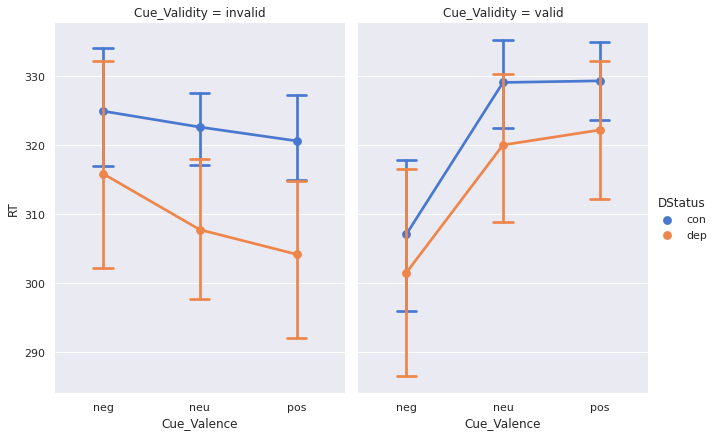

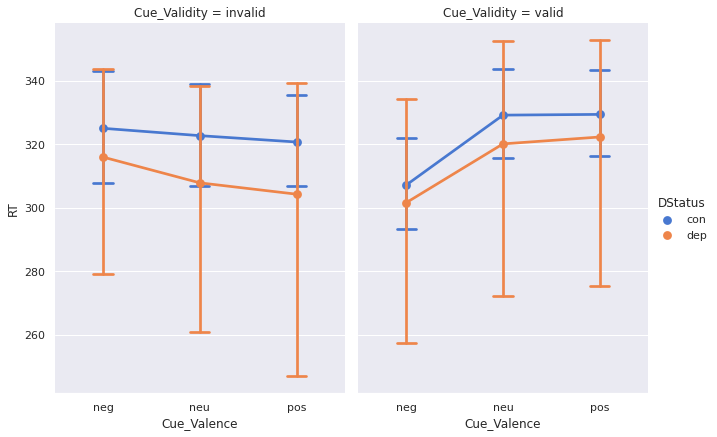

In [6]:
# set seaborn visual style
sns.set(style="darkgrid")
# Draw a pointplot to show pulse as a function of three categorical factors
for dataset in anovas:
    interact_plot = sns.catplot(x="Cue_Valence", y="RT", hue="DStatus", col="Cue_Validity", ci=95, n_boot=1000,
                                capsize=.2, palette="muted", height=6, aspect=.75, kind="point", data=dataset)
    interact_plot.despine(left=True)
    # # save plot
    # interact_plot.savefig("RT_322_interact.png")

Build three-way ANOVA design and calculate the F-test

In [15]:
# check whether variances are equal using Levene tests
for dataset in anovas:
    homoscedast_DStatus = pg.homoscedasticity(data=anova, dv='RT', group='DStatus')
    homoscedast_Valence = pg.homoscedasticity(data=anova, dv='RT', group='Cue_Valence')
    homoscedast_Validity = pg.homoscedasticity(data=anova, dv='RT', group='Cue_Validity')
    # put all into list
    homoscedast = [homoscedast_DStatus, homoscedast_Valence, homoscedast_Validity]
    # inspect the results
    for test in homoscedast:
        print(test)

                W          pval  equal_var
levene  102.77696  4.767290e-24      False
                W          pval  equal_var
levene  15.035238  3.013443e-07      False
               W      pval  equal_var
levene  4.963112  0.025913      False
                W          pval  equal_var
levene  102.77696  4.767290e-24      False
                W          pval  equal_var
levene  15.035238  3.013443e-07      False
               W      pval  equal_var
levene  4.963112  0.025913      False


In [7]:
# run the full ANOVA
FED_anova = pg.anova(data=anova, dv='RT', between=['DStatus', 'Cue_Valence', 'Cue_Validity'], ss_type=3).round(3)  # round to three place digits
FED_meanRTs_anova = pg.anova(data=anova_submeans, dv='RT', between=['DStatus', 'Cue_Valence', 'Cue_Validity'], ss_type=3).round(3)  # round to three place digits

In [8]:
# main effect DStatus significant, Interaction Valence-Validity too, BUT neither of their main effects! -> simple effects!^^
# fix the error variance (residual variance  from full ANOVA)
err_MS = FED_anova.MS[FED_anova.Source == 'Residual'].values
err_dof = FED_anova.DF[FED_anova.Source == 'Residual'].values

# -> simple effects as two-way ANOVA only for valid trials
simpleeff_valid = pg.anova(data=anova[anova['Cue_Validity'] == "valid"], dv='RT', between=['DStatus', 'Cue_Valence'], ss_type=3).round(3)  # round to three place digits
# calculate corrected F value using the residual variance  from full ANOVA
vale_MS = simpleeff_valid.MS[simpleeff_valid.Source == 'Cue_Valence'].values
vale_dof = simpleeff_valid.DF[simpleeff_valid.Source == 'Cue_Valence'].values
correctF_valence = vale_MS / err_MS
correctp_valence = 1 - sp.stats.f.cdf(correctF_valence, vale_dof, err_dof)
# insert the correct value into dataframe
simpleeff_valid.insert(6, 'F_corr', [np.nan, *correctF_valence, np.nan, np.nan])  # lose the brackets^^
simpleeff_valid.insert(7, 'p_corr', [np.nan, *correctp_valence, np.nan, np.nan])  # lose the brackets^^

# -> simple effects as two-way ANOVA only for invalid trials
simpleeff_invalid = pg.anova(data=anova[anova['Cue_Validity'] == "invalid"], dv='RT', between=['DStatus', 'Cue_Valence'], ss_type=3).round(3)  # round to three place digits
# calculate corrected F value using the residual variance  from full ANOVA
vale_MS = simpleeff_invalid.MS[simpleeff_invalid.Source == 'Cue_Valence'].values
vale_dof = simpleeff_invalid.DF[simpleeff_invalid.Source == 'Cue_Valence'].values
correctF_valence = vale_MS / err_MS
correctp_valence = 1 - sp.stats.f.cdf(correctF_valence, vale_dof, err_dof)
# insert the correct value into dataframe
simpleeff_invalid.insert(6, 'F_corr', [np.nan, *correctF_valence, np.nan, np.nan])  # lose the brackets^^
simpleeff_invalid.insert(7, 'p_corr', [np.nan, *correctp_valence, np.nan, np.nan])  # lose the brackets^^

Plot three-way ANOVA results

In [18]:
FED_anova

,Source,SS,DF,MS,F,p-unc,np2
0,DStatus,2.989308e+05,1.0,298930.835,12.173,0.000,0.001
1,Cue_Valence,1.261261e+05,2.0,63063.037,2.568,0.077,0.000
2,Cue_Validity,1.356578e+04,1.0,13565.783,0.552,0.457,0.000
3,DStatus * Cue_Valence,1.276030e+04,2.0,6380.152,0.260,0.771,0.000
4,DStatus * Cue_Validity,2.688208e+04,1.0,26882.075,1.095,0.295,0.000
5,Cue_Valence * Cue_Validity,4.719226e+05,2.0,235961.279,9.608,0.000,0.002
6,DStatus * Cue_Valence * Cue_Validity,3.986043e+03,2.0,1993.021,0.081,0.922,0.000
7,Residual,2.737710e+08,11148.0,24557.861,NaN,NaN,NaN


In [12]:
simpleeff_valid

,Source,SS,DF,MS,F,p-unc,F_corr,p_corr,np2
0,DStatus,7.329054e+04,1,73290.544,2.872,0.090,NaN,NaN,0.001
1,Cue_Valence,5.413986e+05,2,270699.289,10.609,0.000,11.022918,0.000017,0.004
2,DStatus * Cue_Valence,2.846830e+03,2,1423.415,0.056,0.946,NaN,NaN,0.000
3,Residual,1.422220e+08,5574,25515.243,NaN,NaN,NaN,NaN,NaN


In [13]:
simpleeff_invalid

,Source,SS,DF,MS,F,p-unc,F_corr,p_corr,np2
0,DStatus,2.524560e+05,1.0,252455.959,10.697,0.001,NaN,NaN,0.002
1,Cue_Valence,6.087552e+04,2.0,30437.761,1.290,0.275,1.23943,0.289589,0.000
2,DStatus * Cue_Valence,1.383800e+04,2.0,6918.998,0.293,0.746,NaN,NaN,0.000
3,Residual,1.315491e+08,5574.0,23600.479,NaN,NaN,NaN,NaN,NaN


In [19]:
FED_meanRTs_anova

,Source,SS,DF,MS,F,p-unc,np2
0,DStatus,9968.056,1.0,9968.056,1.274,0.260,0.004
1,Cue_Valence,4244.277,2.0,2122.138,0.271,0.763,0.002
2,Cue_Validity,452.360,1.0,452.360,0.058,0.810,0.000
3,DStatus * Cue_Valence,429.211,2.0,214.605,0.027,0.973,0.000
4,DStatus * Cue_Validity,896.401,1.0,896.401,0.115,0.735,0.000
5,Cue_Valence * Cue_Validity,15846.357,2.0,7923.179,1.012,0.364,0.006
6,DStatus * Cue_Valence * Cue_Validity,132.629,2.0,66.315,0.008,0.992,0.000
7,Residual,2817420.849,360.0,7826.169,NaN,NaN,NaN


In [8]:
# full list of table plotting formats in pingouin:
# "plain" "simple" "github""grid" "fancy_grid" "pipe""orgtbl" "jira""presto" "pretty""psql" "rst" "mediawiki" "moinmoin" "youtrack" "html" "unsafehtml" "latex"
# "latex_raw" "latex_booktabs" "latex_longtable" "textile""tsv"
pg.print_table(FED_anova, tablefmt="latex")
pg.print_table(simpleeff_valid, tablefmt="latex")
pg.print_table(simpleeff_invalid, tablefmt="latex")


ANOVA SUMMARY

\begin{tabular}{lrrrrrr}
\hline
 Source                               &            SS &        DF &         MS &       F &   p-unc &     np2 \\
\hline
 DStatus                              &    298930.835 &     1.000 & 298930.835 &  12.173 &   0.000 &   0.001 \\
 Cue\_Valence                          &    126126.075 &     2.000 &  63063.037 &   2.568 &   0.077 &   0.000 \\
 Cue\_Validity                         &     13565.783 &     1.000 &  13565.783 &   0.552 &   0.457 &   0.000 \\
 DStatus * Cue\_Valence                &     12760.303 &     2.000 &   6380.152 &   0.260 &   0.771 &   0.000 \\
 DStatus * Cue\_Validity               &     26882.075 &     1.000 &  26882.075 &   1.095 &   0.295 &   0.000 \\
 Cue\_Valence * Cue\_Validity           &    471922.558 &     2.000 & 235961.279 &   9.608 &   0.000 &   0.002 \\
 DStatus * Cue\_Valence * Cue\_Validity &      3986.043 &     2.000 &   1993.021 &   0.081 &   0.922 &   0.000 \\
 Residual                             & 2

Calculate Cue Validity (CV), Attentional Engagement (AE), and Difficulty in Attentional Disengagement (DAD) based on subject RT means for each condition

In [9]:
# create RT means for smallest increment (validity)
# copy data to avoid accidents
eect_ttest = anova.copy()

# define list of subject numbers
fed_nums = [num for num in range(7, 69)]

# sort data by subject, valence and validity
eect_ttest.sort_values(['Subject', 'Cue_Valence', 'Cue_Validity'], inplace = True)

# list RT by subject, valence and validity, respectively
rts = {}
for sub in eect_ttest['Subject'].unique():
    for valence in eect_ttest['Cue_Valence'].unique():
        for valid in eect_ttest['Cue_Validity'].unique():
            rts[f"{sub}_{valence}_{valid}"] = eect_ttest.loc[(eect_ttest['Subject'] == sub)
                                                           & (eect_ttest['Cue_Valence'] == valence) 
                                                           & (eect_ttest['Cue_Validity'] == valid), 'RT'].tolist()

In [10]:
# calculate CV for each valence per subject
mean_cv = {}
# start at subject index level
for sub in fed_nums:
    # iterate across valences
    for val in valence_cats:
        # create list for validity-referenced combos
        validity = []
        # go through combinations of conditions by subject
        for combo in rts.keys():
            # fix the subject ID
            if (int(combo.split('_', 1)[0]) == sub and combo.split('_', 2)[1]) == val:
                # collect validities
                validity.append(combo)
        #print(validity)
        # calculate the mean of the inv-v difference by valence
        mean_cv[f"{sub}_{val}"] = np.mean([inv - v for inv, v in zip(rts[validity[0]], rts[validity[1]])])

# transfer to pd.dataframe
mean_cv = (pd.DataFrame.from_dict(mean_cv, orient='index', columns=['mean_CV']).rename_axis('FEDbyvalence').reset_index())

['7_neg_invalid', '7_neg_valid']
['7_pos_invalid', '7_pos_valid']
['7_neu_invalid', '7_neu_valid']
['8_neg_invalid', '8_neg_valid']
['8_pos_invalid', '8_pos_valid']
['8_neu_invalid', '8_neu_valid']
['9_neg_invalid', '9_neg_valid']
['9_pos_invalid', '9_pos_valid']
['9_neu_invalid', '9_neu_valid']
['10_neg_invalid', '10_neg_valid']
['10_pos_invalid', '10_pos_valid']
['10_neu_invalid', '10_neu_valid']
['11_neg_invalid', '11_neg_valid']
['11_pos_invalid', '11_pos_valid']
['11_neu_invalid', '11_neu_valid']
['12_neg_invalid', '12_neg_valid']
['12_pos_invalid', '12_pos_valid']
['12_neu_invalid', '12_neu_valid']
['13_neg_invalid', '13_neg_valid']
['13_pos_invalid', '13_pos_valid']
['13_neu_invalid', '13_neu_valid']
['14_neg_invalid', '14_neg_valid']
['14_pos_invalid', '14_pos_valid']
['14_neu_invalid', '14_neu_valid']
['15_neg_invalid', '15_neg_valid']
['15_pos_invalid', '15_pos_valid']
['15_neu_invalid', '15_neu_valid']
['16_neg_invalid', '16_neg_valid']
['16_pos_invalid', '16_pos_valid']
['1

In [11]:
# calculate AE for each valence per subject
mean_ae = {}
# start at subject index level
for sub in fed_nums:
    # iterate across valences
    ref = valence_cats[-1]  # neutral is always reference
    for val in valence_cats[:-1]:
        # go through combinations of conditions by subject
        for combo in rts.keys():
            # set valid neutral reference
            reference = f"{sub}_{ref}_valid"
            # fix the subject ID, and validity to valid
            if (int(combo.split('_', 1)[0]) == sub and combo.split('_', 2)[1] == val and combo.rsplit('_', 1)[1]) == "valid":
                # print(reference, combo)
                # calculate the mean of the vneu-vemo difference by valence
                mean_ae[f"{sub}_{val}"] = np.mean([vneu - vemo for vneu, vemo in zip(rts[reference], rts[combo])])

# transfer to pd.dataframe
mean_ae = (pd.DataFrame.from_dict(mean_ae, orient='index', columns=['mean_AE']).rename_axis('FEDbyvalence').reset_index())

In [12]:
# calculate DAD for each valence per subject
mean_dad = {}
# start at subject index level
for sub in fed_nums:
    # iterate across valences
    ref = valence_cats[-1]  # neutral is always reference
    for val in valence_cats[:-1]:
        # go through combinations of conditions by subject
        for combo in rts.keys():
            # set invalid neutral reference
            reference = f"{sub}_{ref}_invalid"
            # fix the subject ID, and validity to invalid
            if (int(combo.split('_', 1)[0]) == sub and combo.split('_', 2)[1] == val and combo.rsplit('_', 1)[1]) == "invalid":
                # print(reference, combo)
                # calculate the mean of the invemo-invneu difference by valence
                mean_dad[f"{sub}_{val}"] = np.mean([invemo - invneu for invemo, invneu in zip(rts[combo], rts[reference])])

# transfer to pd.dataframe
mean_dad = (pd.DataFrame.from_dict(mean_dad, orient='index', columns=['mean_DAD']).rename_axis('FEDbyvalence').reset_index())

In [ ]:
# JAY's ORIGINAL QUOTE FROM 5 YEARS AGO:
# What I did was to run the CV equation on the individual subject means instead of the overall mean by condition. In MATLAB, it looked like this for positive CV:

# datastruct.CV_POS = (datastruct.RT_POS_INVAL - datastruct.RT_POS_VALID);
# CV_Positive = mean(datastruct.CV_POS(1,:));

# So datastruct.CV_POS has the cue validity score for positive stimuli for each subject. Then I take the mean with the next line, and those are the CV scores I sent you guys last night.

In [11]:
# create RT means for smallest increment (validity)
# copy data to avoid accidents
eect_ttest = anova_submeans.copy()

# define list of subject numbers
fed_nums = [num for num in range(7, 69)]

# sort data by subject, valence and validity
eect_ttest.sort_values(['Subject', 'Cue_Valence', 'Cue_Validity'], inplace = True)

# list RT by subject, valence and validity, respectively
rts = {}
for sub in eect_ttest['Subject'].unique():
    for valence in eect_ttest['Cue_Valence'].unique():
        for valid in eect_ttest['Cue_Validity'].unique():
            rts[f"{sub}_{valence}_{valid}"] = eect_ttest.loc[(eect_ttest['Subject'] == sub)
                                                           & (eect_ttest['Cue_Valence'] == valence) 
                                                           & (eect_ttest['Cue_Validity'] == valid), 'RT'].tolist()

In [12]:
# calculate CV for each valence per subject
mean_cv = {}
# start at subject index level
for sub in fed_nums:
    # iterate across valences
    for val in valence_cats:
        # create list for validity-referenced combos
        validity = []
        # go through combinations of conditions by subject
        for combo in rts.keys():
            # fix the subject ID
            if (int(combo.split('_', 1)[0]) == sub and combo.split('_', 2)[1]) == val:
                # collect validities
                validity.append(combo)
        #print(validity)
        # calculate the inv-v difference by valence
        mean_cv[f"{sub}_{val}"] = [inv - v for inv, v in zip(rts[validity[0]], rts[validity[1]])]

# transfer to pd.dataframe
mean_cv = (pd.DataFrame.from_dict(mean_cv, orient='index', columns=['mean_CV']).rename_axis('FEDbyvalence').reset_index())

In [13]:
# calculate AE for each valence per subject
mean_ae = {}
# start at subject index level
for sub in fed_nums:
    # iterate across valences
    ref = valence_cats[-1]  # neutral is always reference
    for val in valence_cats[:-1]:
        # go through combinations of conditions by subject
        for combo in rts.keys():
            # set valid neutral reference
            reference = f"{sub}_{ref}_valid"
            # fix the subject ID, and validity to valid
            if (int(combo.split('_', 1)[0]) == sub and combo.split('_', 2)[1] == val and combo.rsplit('_', 1)[1]) == "valid":
                #print(reference, combo)
                # calculate the vneu-vemo difference by valence
                mean_ae[f"{sub}_{val}"] = [vneu - vemo for vneu, vemo in zip(rts[reference], rts[combo])]

# transfer to pd.dataframe
mean_ae = (pd.DataFrame.from_dict(mean_ae, orient='index', columns=['mean_AE']).rename_axis('FEDbyvalence').reset_index())

In [14]:
# calculate DAD for each valence per subject
mean_dad = {}
# start at subject index level
for sub in fed_nums:
    # iterate across valences
    ref = valence_cats[-1]  # neutral is always reference
    for val in valence_cats[:-1]:
        # go through combinations of conditions by subject
        for combo in rts.keys():
            # set invalid neutral reference
            reference = f"{sub}_{ref}_invalid"
            # fix the subject ID, and validity to invalid
            if (int(combo.split('_', 1)[0]) == sub and combo.split('_', 2)[1] == val and combo.rsplit('_', 1)[1]) == "invalid":
                #print(combo, reference)
                # calculate the invemo-invneu difference by valence
                mean_dad[f"{sub}_{val}"] = [invemo - invneu for invemo, invneu in zip(rts[combo], rts[reference])]

# transfer to pd.dataframe
mean_dad = (pd.DataFrame.from_dict(mean_dad, orient='index', columns=['mean_DAD']).rename_axis('FEDbyvalence').reset_index())

In [15]:
# add group column to each variable's dataframe
for frame in [mean_cv, mean_ae, mean_dad]:
    # copy Subject, Condition lists and transform to integers
    frame['FED'] = frame['FEDbyvalence'].apply(lambda x: x.split('_', 1)[0])
    frame['Valence'] = frame['FEDbyvalence'].apply(lambda x: x.split('_', 1)[1])
    # copy FED again to obtain DStatus list
    frame['DStatus'] = frame['FED']
    # check and change by group
    frame.loc[frame['FED'].astype(int).isin(mdd), 'DStatus'] = "dep"
    frame.loc[frame['FED'].astype(int).isin(control), 'DStatus'] = "con"
    # finally, sort the dataframe by DStatus and FED
    frame.sort_values(['DStatus', 'Valence', 'FED'], inplace = True)
    # drop FEDbyCondition
    frame.drop(columns='FEDbyvalence', inplace=True)

Inspect and make sure that all variables look OK

In [16]:
mean_cv

,mean_CV,FED,Valence,DStatus
9,32.904195,10,neg,con
15,33.429874,12,neg,con
18,54.812034,13,neg,con
24,52.076000,15,neg,con
27,10.367989,16,neg,con
...,...,...,...,...
136,-30.413742,52,pos,dep
145,-45.678903,55,pos,dep
151,-19.545398,57,pos,dep
157,-65.938613,59,pos,dep


In [17]:
mean_ae

,mean_AE,FED,Valence,DStatus
6,33.252000,10,neg,con
10,31.385000,12,neg,con
12,44.294667,13,neg,con
16,18.425333,15,neg,con
18,44.665000,16,neg,con
...,...,...,...,...
91,-6.875667,52,pos,dep
97,-1.901000,55,pos,dep
101,-20.750000,57,pos,dep
105,-33.893000,59,pos,dep


In [18]:
mean_dad

,mean_DAD,FED,Valence,DStatus
6,18.411529,10,neg,con
10,12.129874,12,neg,con
12,-15.314632,13,neg,con
16,-1.122333,15,neg,con
18,0.082989,16,neg,con
...,...,...,...,...
91,35.609258,52,pos,dep
97,3.072763,55,pos,dep
101,18.593269,57,pos,dep
105,-34.714946,59,pos,dep


Calculate two-sided t-tests (un)like Koster (2005)

In [19]:
# calculate cauchy scaling factor of Koster et al. (2005)
# - original: https://doi.org/10.3758/PBR.16.2.225; recent implimentation: https://doi.org/10.1080/00031305.2018.1562983

# transfer t_vals to cohens d for basing on propability density function
smallest_t = 2.15
largest_t = 2.72
small_cohen = pg.compute_effsize_from_t(smallest_t, nx=20, ny=20, eftype='cohen')
large_cohen = pg.compute_effsize_from_t(largest_t, N=15, eftype='cohen')
# spectrum based on Exp1 & Exp2 results
# t-values are between 0 and 1.4, round up
value_halfwidth = 2
# set scaling factor required for estimated 80% probability that the true effect sizes lie within the spectrum (+2 - -2)
cauchy_r = 0.707
# control the probability
effect_prob_est = sp.stats.cauchy.cdf(value_halfwidth, 0, cauchy_r) - sp.stats.cauchy.cdf(-value_halfwidth, 0, cauchy_r)

In [20]:
# run a two-sided t-test with appropriate p-level threshold (unlike Koster ...)
# for CV
# neg
cvneg_mdd = mean_cv['mean_CV'][(mean_cv['Valence'] == "neg") & (mean_cv['DStatus'] == "dep")].tolist()
cvneg_con = mean_cv['mean_CV'][(mean_cv['Valence'] == "neg") & (mean_cv['DStatus'] == "con")].tolist()
# pos
cvpos_mdd = mean_cv['mean_CV'][(mean_cv['Valence'] == "pos") & (mean_cv['DStatus'] == "dep")].tolist()
cvpos_con = mean_cv['mean_CV'][(mean_cv['Valence'] == "pos") & (mean_cv['DStatus'] == "con")].tolist()
# neu
cvneu_mdd = mean_cv['mean_CV'][(mean_cv['Valence'] == "neu") & (mean_cv['DStatus'] == "dep")].tolist()
cvneu_con = mean_cv['mean_CV'][(mean_cv['Valence'] == "neu") & (mean_cv['DStatus'] == "con")].tolist()
# put all into tupled list
cv_testbtw = [(cvneg_mdd, cvneg_con), (cvpos_mdd, cvpos_con), (cvneu_mdd, cvneu_con)]
cv_testwithin = [[group[0] for group in cv_testbtw], [group[1] for group in cv_testbtw]]

# test all valences separately between and within group
# build empty list to hold all tests
ttests_cv_all = []
# first compare valences between groups with a 2-sample t-test
for valence in cv_testbtw:
    ttests_cv = pg.ttest(valence[0], valence[1], paired=False, tail='two-sided', r=cauchy_r, confidence=0.95)
    # add condition ID
    ttests_cv.insert(0, "ConditionID", f"cv_btw_{valence_cats[cv_testbtw.index(valence)]}")
    # add (partial) eta-squared estimate to the dataframe
    ttests_cv.insert(7, "eta-squared", pg.compute_effsize(valence[0], valence[1], paired=False, eftype='eta-square'))
    # put the finish dataframe into list
    ttests_cv_all.append(ttests_cv)

# Now look at the valences within groups with a paired t-test
for group in cv_testwithin:
    # compare neg and pos against neu
    for valence in [0, 1]:
        ttests_cv = pg.ttest(group[valence], group[2], paired=True, tail='two-sided', r=cauchy_r, confidence=0.95)
        # add condition and group ID (0 means control^^)
        ttests_cv.insert(0, "ConditionID", f"cv_within_{group_cats[cv_testwithin.index(group)]}_{valence_cats[[0, 1].index(valence)]}")
        # add (partial) eta-squared estimate to the dataframe
        ttests_cv.insert(7, "eta-squared", pg.compute_effsize(group[valence], group[2], paired=True, eftype='eta-square'))
        # put the finish dataframe into list
        ttests_cv_all.append(ttests_cv)

# concat list to dataframe
ttests_cv_all = pd.concat(ttests_cv_all)

In [21]:
# test whether or not all t-test RT lists have the same length
for group in cv_testwithin:
    print(f"Negative CV {len(group[0])}; Positive CV {len(group[1])}; Neutral CV {len(group[2])}")

Negative CV 31; Positive CV 31; Neutral CV 31
Negative CV 31; Positive CV 31; Neutral CV 31


In [22]:
# run a two-sided t-test with appropriate p-level threshold (unlike Koster ...)
# for AE
# neg
aeneg_mdd = mean_ae['mean_AE'][(mean_ae['Valence'] == "neg") & (mean_ae['DStatus'] == "dep")].tolist()
aeneg_con = mean_ae['mean_AE'][(mean_ae['Valence'] == "neg") & (mean_ae['DStatus'] == "con")].tolist()
# pos
aepos_mdd = mean_ae['mean_AE'][(mean_ae['Valence'] == "pos") & (mean_ae['DStatus'] == "dep")].tolist()
aepos_con = mean_ae['mean_AE'][(mean_ae['Valence'] == "pos") & (mean_ae['DStatus'] == "con")].tolist()
# put all into tupled list (no within comparisons here)
ae_testbtw = [(aeneg_mdd, aeneg_con), (aepos_mdd, aepos_con)]

# test all valences separately between and within group
# build empty list to hold all tests
ttests_ae_all = []
# first compare valences between groups with a 2-sample t-test
for valence in ae_testbtw:
    ttests_ae = pg.ttest(valence[0], valence[1], paired=False, tail='two-sided', r=cauchy_r, confidence=0.95)
    # add condition ID
    ttests_ae.insert(0, "ConditionID", f"ae_btw_{valence_cats[ae_testbtw.index(valence)]}")
    # add (partial) eta-squared estimate to the dataframe
    ttests_ae.insert(7, "eta-squared", pg.compute_effsize(valence[0], valence[1], paired=False, eftype='eta-square'))
    # put the finish dataframe into list
    ttests_ae_all.append(ttests_ae)

# concat list to dataframe
ttests_ae_all = pd.concat(ttests_ae_all)

In [23]:
# run a two-sided t-test with appropriate p-level threshold (unlike Koster ...)
# for DAD
# neg
dadneg_mdd = mean_dad['mean_DAD'][(mean_dad['Valence'] == "neg") & (mean_dad['DStatus'] == "dep")].tolist()
dadneg_con = mean_dad['mean_DAD'][(mean_dad['Valence'] == "neg") & (mean_dad['DStatus'] == "con")].tolist()
# pos
dadpos_mdd = mean_dad['mean_DAD'][(mean_dad['Valence'] == "pos") & (mean_dad['DStatus'] == "dep")].tolist()
dadpos_con = mean_dad['mean_DAD'][(mean_dad['Valence'] == "pos") & (mean_dad['DStatus'] == "con")].tolist()
# put all into tupled list (no within comparisons here)
dad_testbtw = [(dadneg_mdd, dadneg_con), (dadpos_mdd, dadpos_con)]

# test all valences separately between and within group
# build empty list to hold all tests
ttests_dad_all = []
# first compare valences between groups with a 2-sample t-test
for valence in dad_testbtw:
    ttests_dad = pg.ttest(valence[0], valence[1], paired=False, tail='two-sided', r=cauchy_r, confidence=0.95)
    # add condition ID
    ttests_dad.insert(0, "ConditionID", f"dad_btw_{valence_cats[dad_testbtw.index(valence)]}")
    # add (partial) eta-squared estimate to the dataframe
    ttests_dad.insert(7, "eta-squared", pg.compute_effsize(valence[0], valence[1], paired=False, eftype='eta-square'))
    # put the finish dataframe into list
    ttests_dad_all.append(ttests_dad)

# concat list to dataframe
ttests_dad_all = pd.concat(ttests_dad_all)

Plot t-test results

In [29]:
# view respective ttest dicts to make sure everything looks as it should
ttests_cv_all

,ConditionID,T,dof,tail,p-val,CI95%,cohen-d,eta-squared,BF10,power
T-test,ecv_btw_neg,-0.313372,60,two-sided,0.755085,"[-25.87, 18.86]",0.079597,0.001581,0.27,0.060964
T-test,ecv_btw_pos,-1.198356,60,two-sided,0.235491,"[-24.86, 6.23]",0.304383,0.022638,0.473,0.218326
T-test,ecv_btw_neu,-0.776735,60,two-sided,0.440366,"[-20.77, 9.15]",0.197291,0.009637,0.334,0.119147
T-test,ecv_within_dep_neg,2.811179,30,two-sided,0.008614,"[7.29, 45.99]",0.607867,0.084564,5.056,0.905631
T-test,ecv_within_dep_pos,-0.863944,30,two-sided,0.394474,"[-19.29, 7.82]",0.167889,0.006997,0.27,0.147826
T-test,ecv_within_con_neg,4.086420,30,two-sided,0.000301,"[12.17, 36.49]",0.817726,0.143226,95.617,0.992716
T-test,ecv_within_con_pos,-0.516283,30,two-sided,0.609441,"[-11.06, 6.6]",0.088506,0.001955,0.217,0.076469


In [30]:
ttests_ae_all

,ConditionID,T,dof,tail,p-val,CI95%,cohen-d,eta-squared,BF10,power
T-test,ae_btw_neg,-0.467297,60,two-sided,0.641980,"[-18.44, 11.46]",0.118694,0.003510,0.284,0.074558
T-test,ae_btw_pos,-0.429936,60,two-sided,0.668782,"[-10.93, 7.06]",0.109204,0.002973,0.28,0.070747


In [31]:
ttests_dad_all

,ConditionID,T,dof,tail,p-val,CI95%,cohen-d,eta-squared,BF10,power
T-test,dad_btw_neg,0.591074,60,two-sided,0.556691,"[-13.83, 25.42]",0.150133,0.005603,0.3,0.089572
T-test,dad_btw_pos,-0.210060,60,two-sided,0.834333,"[-16.51, 13.37]",0.053355,0.000711,0.264,0.054909


In [24]:
# full list of table plotting formats in pingouin:
# "plain" "simple" "github""grid" "fancy_grid" "pipe""orgtbl" "jira""presto" "pretty""psql" "rst" "mediawiki" "moinmoin" "youtrack" "html" "unsafehtml" "latex"
# "latex_raw" "latex_booktabs" "latex_longtable" "textile""tsv"
pg.print_table(ttests_cv_all, tablefmt="latex")
pg.print_table(ttests_ae_all, tablefmt="latex")
pg.print_table(ttests_dad_all, tablefmt="latex")

\begin{tabular}{lrrlrlrrrr}
\hline
 ConditionID       &      T &   dof & tail      &   p-val & CI95\%           &   cohen-d &   eta-squared &   BF10 &   power \\
\hline
 cv\_btw\_neg        & -0.313 &    60 & two-sided &   0.755 & [-25.87  18.86] &     0.080 &         0.002 &  0.270 &   0.061 \\
 cv\_btw\_pos        & -1.198 &    60 & two-sided &   0.235 & [-24.86   6.23] &     0.304 &         0.023 &  0.473 &   0.218 \\
 cv\_btw\_neu        & -0.777 &    60 & two-sided &   0.440 & [-20.77   9.15] &     0.197 &         0.010 &  0.334 &   0.119 \\
 cv\_within\_dep\_neg &  2.811 &    30 & two-sided &   0.009 & [ 7.29 45.99]   &     0.608 &         0.085 &  5.056 &   0.906 \\
 cv\_within\_dep\_pos & -0.864 &    30 & two-sided &   0.394 & [-19.29   7.82] &     0.168 &         0.007 &  0.270 &   0.148 \\
 cv\_within\_con\_neg &  4.086 &    30 & two-sided &   0.000 & [12.17 36.49]   &     0.818 &         0.143 & 95.617 &   0.993 \\
 cv\_within\_con\_pos & -0.516 &    30 & two-sided &   0.609

Calculate Cue Validity (CV), Attentional Engagement (AE), and Difficulty in Attentional Disengagement (DAD) - group means

In [25]:
# create mean_{variable} by valence for each group
# collect all single values in a dict for extraction into table
Group_vars_decript = {"MDD_mean": {}, "MDD_std": {}, "CON_mean": {}, "CON_std": {}}

for frame in [("mean_CV", mean_cv), ("mean_AE", mean_ae), ("mean_DAD", mean_dad)]:
    # locate Valence and DStatus in frame and set group column to mean_CV across FEDs for those parameters
    for valence in valence_cats:
        # for MDD
        Group_vars_decript["MDD_mean"][f"{frame[0].split('_', 1)[1]}_{valence}"] = frame[1][frame[0]][(frame[1]['DStatus'] == "dep") & (frame[1]['Valence'] == valence)].mean()
        Group_vars_decript["MDD_std"][f"{frame[0].split('_', 1)[1]}_{valence}"] = frame[1][frame[0]][(frame[1]['DStatus'] == "dep") & (frame[1]['Valence'] == valence)].std()
        # for control
        Group_vars_decript["CON_mean"][f"{frame[0].split('_', 1)[1]}_{valence}"] = frame[1][frame[0]][(frame[1]['DStatus'] == "con") & (frame[1]['Valence'] == valence)].mean()
        Group_vars_decript["CON_std"][f"{frame[0].split('_', 1)[1]}_{valence}"] = frame[1][frame[0]][(frame[1]['DStatus'] == "con") & (frame[1]['Valence'] == valence)].std()

# drop all items with nan values (neutral valences for AE, DAD)
for group in Group_vars_decript.keys():
    for item in list(Group_vars_decript[group].items()):
        if item[1] is np.NaN:
            Group_vars_decript[group].pop(item[0])

# transfer dict to pd.dataframe
Group_vars_decript = pd.DataFrame.from_dict(Group_vars_decript, orient='columns')
# make index its own column
Group_vars_decript.insert(0, "Var_Valence", Group_vars_decript.index)

Build summary tables for each variable by group, valence (and validity, if needed)

In [26]:
print(Group_vars_decript)

        Var_Valence   MDD_mean    MDD_std   CON_mean    CON_std
CV_neg       CV_neg  14.358954  52.468369  17.862907  33.508716
CV_pos       CV_pos -18.012495  35.315569  -8.699090  25.004939
CV_neu       CV_neu -12.276753  32.972100  -6.466333  25.447304
AE_neg       AE_neg  18.524548  31.432013  22.017032  27.269306
AE_pos       AE_pos  -2.164419  17.974284  -0.230452  17.441070
DAD_neg     DAD_neg   8.111158  48.154358   2.312208  25.787730
DAD_pos     DAD_pos  -3.571323  34.892993  -2.002305  22.627973


In [27]:
# full list of table plotting formats in pingouin:
# "plain" "simple" "github""grid" "fancy_grid" "pipe""orgtbl" "jira""presto" "pretty""psql" "rst" "mediawiki" "moinmoin" "youtrack" "html" "unsafehtml" "latex"
# "latex_raw" "latex_booktabs" "latex_longtable" "textile""tsv"
pg.print_table(Group_vars_decript, tablefmt="latex")

\begin{tabular}{lrrrr}
\hline
 Var\_Valence   &   MDD\_mean &   MDD\_std &   CON\_mean &   CON\_std \\
\hline
 CV\_neg        &     14.359 &    52.468 &     17.863 &    33.509 \\
 CV\_pos        &    -18.012 &    35.316 &     -8.699 &    25.005 \\
 CV\_neu        &    -12.277 &    32.972 &     -6.466 &    25.447 \\
 AE\_neg        &     18.525 &    31.432 &     22.017 &    27.269 \\
 AE\_pos        &     -2.164 &    17.974 &     -0.230 &    17.441 \\
 DAD\_neg       &      8.111 &    48.154 &      2.312 &    25.788 \\
 DAD\_pos       &     -3.571 &    34.893 &     -2.002 &    22.628 \\
\hline
\end{tabular}



Plot the ANOVA data's descriptives per cell

In [14]:
pd.set_option('display.max_rows', None)
anova_submeans

,RT,Subject,Cue_Valence,Cue_Validity,DStatus
1080,292.314483,7,neg,invalid,con
1260,324.400000,8,neg,invalid,con
1440,312.172759,9,neg,invalid,con
1620,331.795862,10,neg,invalid,con
1980,317.846207,12,neg,invalid,con
2160,339.091034,13,neg,invalid,con
2520,416.560000,15,neg,invalid,con
2700,276.969655,16,neg,invalid,con
2880,265.769310,17,neg,invalid,con
3240,327.416207,19,neg,invalid,con


In [23]:
# copy data to avoid accidents
anova_summary = anova_submeans.copy().drop('Subject', axis=1)

# list RT by group, valence and validity, respectively
for group in anova_summary['DStatus'].unique():
    for valence in anova_summary['Cue_Valence'].unique():
        for valid in anova_summary['Cue_Validity'].unique():
            anova_summary.loc[(anova_summary['DStatus'] == group) & (anova_summary['Cue_Valence'] == valence)
                                                                  & (anova_summary['Cue_Validity'] == valid),
                               # replace the individual sub_mean RT values with the mean by valence and validity
                               'RT_mean'] = anova_summary["RT"][(anova_summary['DStatus'] == group)
                                                         & (anova_summary['Cue_Valence'] == valence)
                                                         & (anova_summary['Cue_Validity'] == valid)].mean()
            anova_summary.loc[(anova_summary['DStatus'] == group) & (anova_summary['Cue_Valence'] == valence)
                                                                  & (anova_summary['Cue_Validity'] == valid),
                               # replace the individual sub_mean RT values with the mean by valence and validity
                               'RT_std'] = anova_summary["RT"][(anova_summary['DStatus'] == group)
                                                         & (anova_summary['Cue_Valence'] == valence)
                                                         & (anova_summary['Cue_Validity'] == valid)].std()

# drop the sub_mean RT column
anova_summary = anova_summary.drop('RT', axis=1)

# drop duplicate lines
anova_summary = anova_summary.drop_duplicates()

# sort
anova_summary.sort_values(['DStatus', 'Cue_Validity', 'Cue_Valence'], inplace = True)

In [24]:
# full list of table plotting formats in pingouin:
# "plain" "simple" "github""grid" "fancy_grid" "pipe""orgtbl" "jira""presto" "pretty""psql" "rst" "mediawiki" "moinmoin" "youtrack" "html" "unsafehtml" "latex"
# "latex_raw" "latex_booktabs" "latex_longtable" "textile""tsv"
pg.print_table(anova_summary, tablefmt="latex")

\begin{tabular}{lllrr}
\hline
 Cue\_Valence   & Cue\_Validity   & DStatus   &   RT\_mean &   RT\_std \\
\hline
 neg           & invalid        & con       &   324.976 &   52.092 \\
 neu           & invalid        & con       &   322.664 &   46.236 \\
 pos           & invalid        & con       &   320.662 &   43.728 \\
 neg           & valid          & con       &   307.113 &   42.588 \\
 neu           & valid          & con       &   329.130 &   41.089 \\
 pos           & valid          & con       &   329.361 &   39.951 \\
 neg           & invalid        & dep       &   315.908 &   90.484 \\
 neu           & invalid        & dep       &   307.796 &  117.527 \\
 pos           & invalid        & dep       &   304.225 &  134.213 \\
 neg           & valid          & dep       &   301.549 &  114.085 \\
 neu           & valid          & dep       &   320.073 &  119.058 \\
 pos           & valid          & dep       &   322.238 &  121.858 \\
\hline
\end{tabular}



# Testing Zone

In [ ]:


# # transfer to pd.dataframe
# rts_pd = (pd.DataFrame.from_dict(rts, orient='index', columns=['mean_RT']).rename_axis('condition').reset_index())